In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
col_names = ['text', 'emotion']
df_train = pd.read_csv('train.txt', sep=';', header=None, names=col_names)
df_val = pd.read_csv('val.txt', sep=';', header=None, names=col_names)
df_test = pd.read_csv('test.txt', sep=';', header=None, names=col_names)

In [4]:
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [5]:
print("Dataset loaded successfully. Shape of the combined data:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Dataset loaded successfully. Shape of the combined data: (20000, 2)

First 5 rows of the dataset:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Emotion distribution:
emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


In [6]:

# --- 2. Preprocess Tweets ---
# Download stopwords from NLTK
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions (@username)
    text = re.sub(r'\@\w+', '', text)
    # Remove hashtags (#)
    text = re.sub(r'#', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text_tokens = text.split()
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [7]:
# Apply the preprocessing function to the 'text' column
print("\nPreprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")
print("\nExample of original vs. cleaned text:")
print("Original:", df['text'].iloc[0])
print("Cleaned: ", df['cleaned_text'].iloc[0])


Preprocessing text data...
Preprocessing complete.

Example of original vs. cleaned text:
Original: i didnt feel humiliated
Cleaned:  didnt feel humiliated


In [8]:
# Separate features (X) and target (y)
X = df['cleaned_text']
y = df['emotion']

In [9]:
# Initialize the TF-IDF Vectorizer
# max_features is set to 5000 to use the top 5000 words as features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [10]:
# For simplicity, we'll do a standard 80/20 random split on the combined data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [12]:
print(f"\nText representation complete. Shape of TF-IDF matrices:")
print("Train:", X_train_tfidf.shape)
print("Test:", X_test_tfidf.shape)


Text representation complete. Shape of TF-IDF matrices:
Train: (16000, 5000)
Test: (4000, 5000)


In [13]:
# --- 4. Train a Logistic Regression Model ---
# Logistic Regression is a robust and interpretable model for classification.

print("\nTraining the Logistic Regression model...")
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)
print("Model training complete.")


Training the Logistic Regression model...
Model training complete.


In [15]:
# --- 5. Evaluate the Model ---
# We will evaluate the model's performance on the unseen test data.

print("\nEvaluating the model...")
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Evaluating the model...
Model Accuracy: 87.80%

Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.80      0.85       542
        fear       0.88      0.80      0.84       475
         joy       0.86      0.96      0.91      1352
        love       0.87      0.70      0.77       328
     sadness       0.89      0.94      0.91      1159
    surprise       0.88      0.58      0.70       144

    accuracy                           0.88      4000
   macro avg       0.88      0.80      0.83      4000
weighted avg       0.88      0.88      0.87      4000



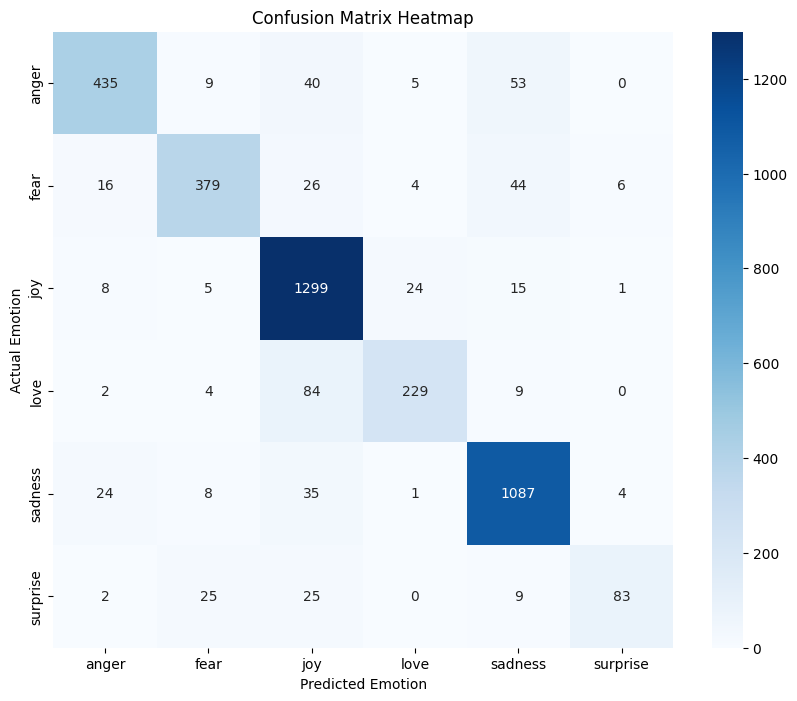

In [16]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
emotion_labels = sorted(y.unique())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.show()